# Week 4 Lab: Simple Linear Regression (OLS)

**QM 2023 -- Statistics II / Data Analytics**  
**Spring 2026 | University of Tulsa**

---

## What You Will Learn

By the end of this lab, you will be able to:

1. **Fit** a simple OLS regression in Python using `statsmodels`
2. **Read** the regression output table and identify key statistics
3. **Interpret** the slope coefficient in economic units
4. **Assess** statistical significance using t-statistics, p-values, and confidence intervals
5. **Visualize** a regression relationship with a scatter plot and fitted line
6. **Evaluate** model fit using R-squared

---

### The Big Question

> *Do higher-dividend-yield REITs earn different returns than lower-yield REITs?*

We will answer this by estimating:

$$\text{ret} = \beta_0 + \beta_1 \times \text{div\_yield} + \varepsilon$$

where:
- `ret` = annual (12-month) return for an individual REIT (decimal, e.g., 0.05 = 5%)
- `div_yield` = dividend yield (12-month dividends / market equity, e.g., 0.05 = 5%)
- $\beta_1$ = the **marginal effect** of dividend yield on returns

---

## Part 1: Setup and Data Loading

First, let's import the libraries we need and load our dataset.

In [74]:
# Standard imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# The key package for regression
from statsmodels.formula.api import ols

# Make plots look clean
sns.set_theme(style="whitegrid", context="notebook")

print("All imports successful!")

All imports successful!


In [75]:
# Load the REIT sample (annual data, 2004-2024)
df = pd.read_csv("data/REIT_sample_annual_2004_2024.csv")

# Create ret, div_yield, and mcap from the raw columns
# ret12 = annual return; div12m_me = dividend yield; mcap = market cap in millions
df["ret"] = df["ret12"]
df["div_yield"] = df["div12m_me"]
df["mcap"] = np.exp(df["lnmcap"]) / 1000  # CRSP mcap in thousands -> millions

# Drop rows with missing ret, div_yield, or mcap
df = df.dropna(subset=["ret", "div_yield", "mcap"])

print(f"Dataset shape: {df.shape[0]} rows x {df.shape[1]} columns")
print(f"Unique REITs: {df['permno'].nunique()}")
print()
df.head()

Dataset shape: 2527 rows x 13 columns
Unique REITs: 246



,year,permno,ticker,comnam,age,div12m_me,ffo_at_reit,beta,lnmcap,ret12,ret,div_yield,mcap
0,2004,10952,UNII,UNI INVEST U S LTD,228.0,0.031295,0.003399,-0.239846,12.241140,0.228164,0.228164,0.031295,207.137929
1,2005,10952,UNII,UNI INVEST U S LTD,240.0,0.053209,0.011787,-0.493774,12.645662,0.048434,0.048434,0.053209,310.413856
2,2006,10952,UNII,UNI INVEST U S LTD,252.0,0.050072,0.010122,-0.502520,13.129318,0.197044,0.197044,0.050072,503.489267
3,2007,10952,UNII,UNI INVEST U S LTD,264.0,0.058712,0.011058,0.203412,13.328322,-0.314575,-0.314575,0.058712,614.351381
4,2008,10952,UNII,UNI INVEST U S LTD,276.0,0.089553,0.009226,0.482287,13.057649,-0.234077,-0.234077,0.089553,468.667626


### Understanding the Variables

| Variable | Meaning | Example |
|:---------|:--------|:--------|
| `permno` | Unique REIT identifier | 10952 |
| `year` | Year | 2021 |
| `ret` | Annual (12-month) return | 0.228 = 22.8% |
| `div_yield` | Dividend yield (div/price) | 0.055 = 5.5% |
| `mcap` | Market cap (millions $) | 2500 |
| `ticker` | Stock ticker | UNII |

**Important:** Returns and dividend yield are in decimal form. 0.01 = 1 percentage point. Market cap is in millions.

In [76]:
# Quick summary statistics for the main variables (ret and div_yield)
print("Summary Statistics")
print("=" * 50)
df[["ret", "div_yield"]].describe().round(4)

Summary Statistics


,ret,div_yield
count,2527.0000,2527.0000
mean,0.1044,0.0558
std,0.2870,0.1756
min,-0.6043,0.0000
25%,-0.0703,0.0301
50%,0.0994,0.0438
75%,0.2720,0.0600
max,1.0234,8.1569


#### Checkpoint 1

Before we model anything, look at the summary statistics above.

- What is the average annual return across REITs?
- What is the range of dividend yield (smallest to largest)?
- Do returns have negative values? What does that mean economically?

---

## Part 2: Looking at the Data First (Always!)

Before running any regression, **always visualize your data**. A scatter plot of returns vs. dividend yield lets us see whether a linear relationship is plausible.

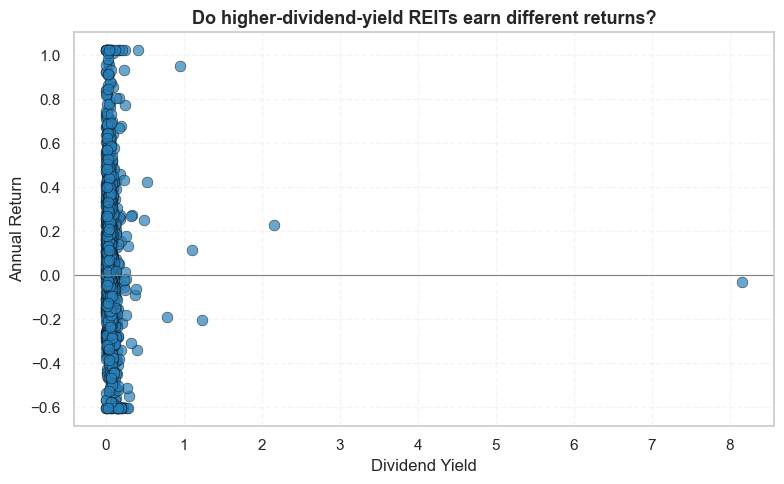

In [77]:
fig, ax = plt.subplots(figsize=(8, 5))

ax.scatter(df["div_yield"], df["ret"],
           color="#2980B9", alpha=0.7, s=60,
           edgecolor="black", linewidth=0.4)

ax.set_xlabel("Dividend Yield", fontsize=12)
ax.set_ylabel("Annual Return", fontsize=12)
ax.set_title("Do higher-dividend-yield REITs earn different returns?", fontsize=13, fontweight="bold")
ax.grid(True, alpha=0.2, linestyle="--")
ax.axhline(0, color="gray", linewidth=0.8, linestyle="-")

plt.tight_layout()
plt.show()

#### Checkpoint 2

Look at the scatter plot above.

- Does the relationship look **linear**? (Could a straight line summarize the pattern?)
- Is the relationship **positive or negative**? (Do higher-yield REITs tend to have higher or lower returns?)
- Are there any obvious **outliers**? (Points far from the cloud—e.g., very high dividend yields on the right?)

Those extreme dividend yields can distort our regression. Below we **winsorize** the data at the 1st and 99th percentiles to address this issue.

---

### Addressing Outliers: Winsorization

**Winsorization** replaces extreme values with the values at the 1st and 99th percentiles. Values below the 1st percentile are set to the 1st percentile; values above the 99th percentile are set to the 99th percentile. This reduces the influence of outliers without dropping observations.

In [78]:
# Winsorize dividend yield at 1st and 99th percentiles
p1 = df["div_yield"].quantile(0.01)
p99 = df["div_yield"].quantile(0.99)
orig_min, orig_max = df["div_yield"].min(), df["div_yield"].max()
df["div_yield"] = df["div_yield"].clip(lower=p1, upper=p99)

print("Winsorized dividend yield at 1% and 99%:")
print(f"  Before: min = {orig_min:.4f}, max = {orig_max:.4f}")
print(f"  After:  min = {p1:.4f} (1st pctl), max = {p99:.4f} (99th pctl)")
print(f"  (Values beyond these bounds have been capped. All analysis below uses winsorized data.)")

Winsorized dividend yield at 1% and 99%:
  Before: min = 0.0000, max = 8.1569
  After:  min = 0.0000 (1st pctl), max = 0.2469 (99th pctl)
  (Values beyond these bounds have been capped. All analysis below uses winsorized data.)


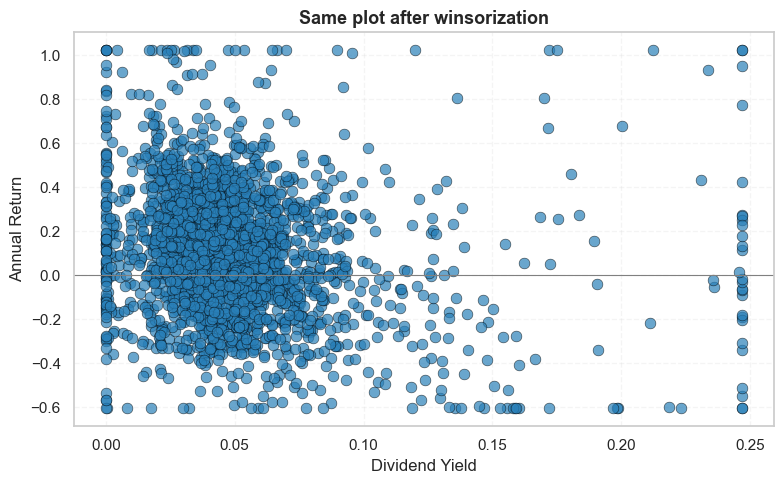

In [79]:
# Same scatter plot after winsorization — compare to the figure above
fig, ax = plt.subplots(figsize=(8, 5))

ax.scatter(df["div_yield"], df["ret"],
           color="#2980B9", alpha=0.7, s=60,
           edgecolor="black", linewidth=0.4)

ax.set_xlabel("Dividend Yield", fontsize=12)
ax.set_ylabel("Annual Return", fontsize=12)
ax.set_title("Same plot after winsorization", fontsize=13, fontweight="bold")
ax.grid(True, alpha=0.2, linestyle="--")
ax.axhline(0, color="gray", linewidth=0.8, linestyle="-")

plt.tight_layout()
plt.show()

---

## Part 3: Fitting Your First OLS Regression

We now use the **winsorized** dividend yield for all analysis below. OLS stands for **Ordinary Least Squares**. It finds the straight line that minimizes the total squared distance between each data point and the line.

In Python, we use `statsmodels` with an R-style formula:

```python
model = ols('Y ~ X', data=df).fit()
```

The `~` means "is predicted by." So `ret ~ div_yield` means:  
*"Annual return is predicted by dividend yield."*

In [80]:
# Fit the OLS regression
model = ols("ret ~ div_yield", data=df).fit()

# Print the full output table
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:                    ret   R-squared:                       0.032
Model:                            OLS   Adj. R-squared:                  0.032
Method:                 Least Squares   F-statistic:                     84.17
Date:                Wed, 11 Feb 2026   Prob (F-statistic):           9.15e-20
Time:                        05:48:20   Log-Likelihood:                -389.20
No. Observations:                2527   AIC:                             782.4
Df Residuals:                    2525   BIC:                             794.1
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      0.1752      0.010     18.349      0.0

---

## Part 4: Reading the Regression Output

That output table has a lot of numbers. Let's break it down into three sections.

### Section 1: Top Panel (Model Info)

| What to look for | What it tells you |
|:-----------------|:------------------|
| **Dep. Variable** | What we're predicting (`ret`) |
| **R-squared** | How much variance the model explains (0 to 1) |
| **No. Observations** | Sample size |

### Section 2: Coefficient Table (The Heart of the Output)

| Column | Meaning |
|:-------|:--------|
| **coef** | The estimated value of the coefficient |
| **std err** | How precise our estimate is (smaller = more precise) |
| **t** | Test statistic: `coef / std err` |
| **P>\|t\|** | p-value: probability of seeing this result if the true effect were zero |
| **[0.025, 0.975]** | 95% confidence interval for the coefficient |

### Section 3: Bottom Panel (Diagnostics)

We'll cover these in detail in **Week 6**. For now, just note they exist.

---

## Part 5: Extracting Key Results

Rather than reading numbers off a big table, we can extract them directly from the model object. This is useful for reports and for checking your work.

In [81]:
# ---- Coefficients ----
intercept = model.params["Intercept"]
slope = model.params["div_yield"]

print("COEFFICIENTS")
print(f"  Intercept (B0): {intercept:.6f}")
print(f"  Slope (B1):     {slope:.6f}")
print()
print(f"  Our estimated equation:")
print(f"  ret = {intercept:.4f} + {slope:.6f} * div_yield")

COEFFICIENTS
  Intercept (B0): 0.175203
  Slope (B1):     -1.413132

  Our estimated equation:
  ret = 0.1752 + -1.413132 * div_yield


In [82]:
# ---- Standard Errors ----
se_intercept = model.bse["Intercept"]
se_slope = model.bse["div_yield"]

print("STANDARD ERRORS (precision of our estimates)")
print(f"  SE(Intercept): {se_intercept:.6f}")
print(f"  SE(Slope):     {se_slope:.6f}")
print()
print("  Smaller SE = more precise estimate")

STANDARD ERRORS (precision of our estimates)
  SE(Intercept): 0.009549
  SE(Slope):     0.154026

  Smaller SE = more precise estimate


In [83]:
# ---- t-statistics and p-values ----
t_slope = model.tvalues["div_yield"]
p_slope = model.pvalues["div_yield"]

print("HYPOTHESIS TEST: Is the slope different from zero?")
print(f"  t-statistic: {t_slope:.2f}")
print(f"  p-value:     {p_slope:.6f}")
print()

# Interpret
if p_slope < 0.001:
    print("  Result: p < 0.001 -- VERY strong evidence of a relationship")
elif p_slope < 0.05:
    print(f"  Result: p = {p_slope:.4f} -- Statistically significant at 5% level")
else:
    print(f"  Result: p = {p_slope:.4f} -- NOT statistically significant at 5% level")

HYPOTHESIS TEST: Is the slope different from zero?
  t-statistic: -9.17
  p-value:     0.000000

  Result: p < 0.001 -- VERY strong evidence of a relationship


In [84]:
# ---- Confidence Interval ----
ci = model.conf_int().loc["div_yield"]
ci_low, ci_high = ci[0], ci[1]

print("95% CONFIDENCE INTERVAL for the slope")
print(f"  [{ci_low:.6f}, {ci_high:.6f}]")
print()
print(f"  We are 95% confident the true marginal effect of div_yield is between {ci_low:.6f} and {ci_high:.6f}.")
print(f"  Does this interval contain 0? {'Yes -- not significant' if ci_low <= 0 <= ci_high else 'No -- significant!'}")

95% CONFIDENCE INTERVAL for the slope
  [-1.715162, -1.111101]

  We are 95% confident the true marginal effect of div_yield is between -1.715162 and -1.111101.
  Does this interval contain 0? No -- significant!


In [85]:
# ---- R-squared ----
r2 = model.rsquared
r2_adj = model.rsquared_adj

print("MODEL FIT")
print(f"  R-squared:          {r2:.4f}")
print(f"  Adjusted R-squared: {r2_adj:.4f}")
print()
print(f"  {r2*100:.1f}% of the variation in returns")
print(f"  is explained by dividend yield.")
print(f"  The remaining {(1-r2)*100:.1f}% is unexplained (other factors, noise).")

MODEL FIT
  R-squared:          0.0323
  Adjusted R-squared: 0.0319

  3.2% of the variation in returns
  is explained by dividend yield.
  The remaining 96.8% is unexplained (other factors, noise).


#### Checkpoint 3

Using the results above, answer these questions (write your answers in the cell below):

1. What is the slope coefficient? What does it mean *in plain English*? (Hint: a 1 percentage point increase in dividend yield means div_yield increases by 0.01.)
2. Is the slope statistically significant? How do you know?
3. What percentage of variation in returns is explained by the model?
4. Does the 95% confidence interval contain zero?

*Your answers here:*

1. ...
2. ...
3. ...
4. ...

---

## Part 6: Writing a Proper Interpretation

In this class, **numbers without words are incomplete**. Here is how a professional analyst would interpret these results.

### The Wrong Way

> "The slope is 0.62 and the p-value is less than 0.05."

This is technically correct but tells the reader nothing useful.

### The Right Way

> "A 1 percentage point increase in dividend yield is associated with a [slope] change in annual return (beta1 = [value], t = [t], p = [p]). This suggests that [higher-yield/lower-yield] REITs earn [higher/lower] returns on average. The model explains [X]% of the variation in returns (R-squared = [value]), indicating that dividend yield is [an important / a weak] predictor. Other factors such as size and sector likely matter as well."

### What Makes This Good?

- **Units are explicit:** "1 percentage point increase in dividend yield" (i.e., div_yield increases by 0.01)
- **Evidence is cited:** t-stat, p-value, R-squared
- **Economic context:** what does the slope *mean* for investors?
- **Limitations acknowledged:** "other factors likely matter"

---

## Part 7: Visualizing the Regression

A scatter plot with the fitted regression line is the standard way to communicate a bivariate relationship. Let's build one for returns vs. dividend yield.

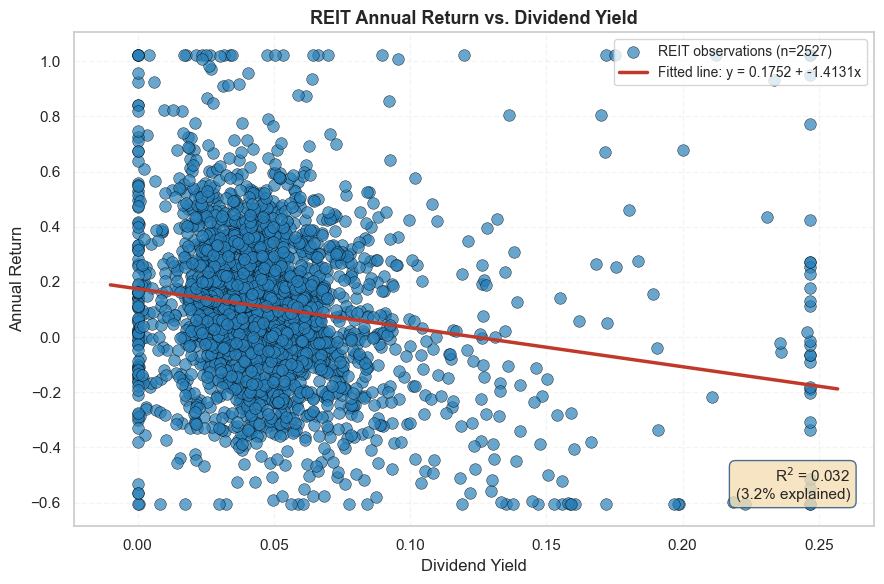

In [86]:
fig, ax = plt.subplots(figsize=(9, 6))

# 1. Scatter plot of the raw data
ax.scatter(df["div_yield"], df["ret"],
           color="#2980B9", alpha=0.7, s=70,
           edgecolor="black", linewidth=0.4,
           label=f"REIT observations (n={len(df)})")

# 2. Fitted regression line
x_range = np.linspace(df["div_yield"].min() - 0.01,
                      df["div_yield"].max() + 0.01, 100)
y_hat = intercept + slope * x_range
ax.plot(x_range, y_hat, color="#C0392B", linewidth=2.5,
        label=f"Fitted line: y = {intercept:.4f} + {slope:.4f}x")

# 3. Labels and formatting
ax.set_xlabel("Dividend Yield", fontsize=12)
ax.set_ylabel("Annual Return", fontsize=12)
ax.set_title("REIT Annual Return vs. Dividend Yield",
             fontsize=13, fontweight="bold")
ax.legend(loc="upper right", fontsize=10)
ax.grid(True, alpha=0.2, linestyle="--")

# 4. R-squared annotation box
ax.text(0.97, 0.05,
        f"R$^2$ = {r2:.3f}\n({r2*100:.1f}% explained)",
        transform=ax.transAxes, fontsize=11,
        ha="right", va="bottom",
        bbox=dict(boxstyle="round,pad=0.4", facecolor="wheat",
                  edgecolor="#1F4E79", alpha=0.8))

plt.tight_layout()
plt.show()

---

## Part 8: Understanding Residuals

**Residuals** are the vertical distances between each data point and the regression line:

$$\text{residual}_i = y_i - \hat{y}_i = \text{actual} - \text{predicted}$$

OLS finds the line that makes the **sum of squared residuals** as small as possible.

Let's visualize what residuals look like.

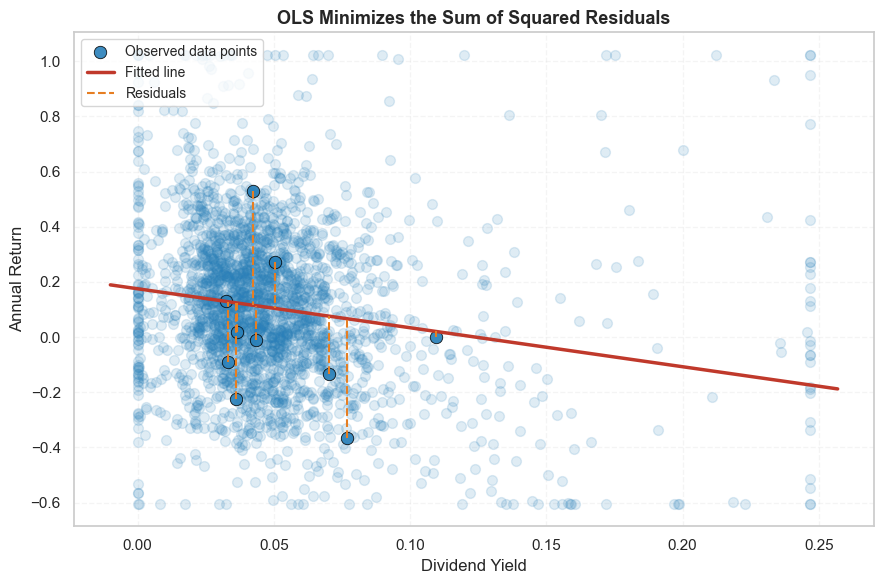

In [87]:
fig, ax = plt.subplots(figsize=(9, 6))

# Pick 10 random points for clarity
np.random.seed(42)
idx = np.sort(np.random.choice(len(df), size=min(10, len(df)), replace=False))
df_sub = df.iloc[idx]
fitted_sub = model.fittedvalues.iloc[idx]

# All points (faded)
ax.scatter(df["div_yield"], df["ret"],
           color="#2980B9", alpha=0.15, s=50)

# Highlighted subset
ax.scatter(df_sub["div_yield"], df_sub["ret"],
           color="#2980B9", alpha=0.9, s=80,
           edgecolor="black", linewidth=0.6,
           label="Observed data points")

# Regression line
ax.plot(x_range, y_hat, color="#C0392B", linewidth=2.5, label="Fitted line")

# Draw residual lines (vertical dashed orange lines)
for i in range(len(df_sub)):
    x_val = df_sub["div_yield"].iloc[i]
    y_obs = df_sub["ret"].iloc[i]
    y_fit = fitted_sub.iloc[i]
    ax.plot([x_val, x_val], [y_obs, y_fit],
            color="#E67E22", linewidth=1.5, linestyle="--",
            label="Residuals" if i == 0 else None)

ax.set_title("OLS Minimizes the Sum of Squared Residuals",
             fontweight="bold", fontsize=13)
ax.set_xlabel("Dividend Yield", fontsize=12)
ax.set_ylabel("Annual Return", fontsize=12)
ax.legend(loc="upper left", fontsize=10)
ax.grid(True, alpha=0.2, linestyle="--")

plt.tight_layout()
plt.show()

The **orange dashed lines** are the residuals. OLS chose the red line specifically because it makes the total area of those squared residual distances as small as possible.

In Week 6, we will check whether these residuals satisfy the **Gauss-Markov assumptions** (constant variance, normality, independence). For now, let's just look at their distribution.

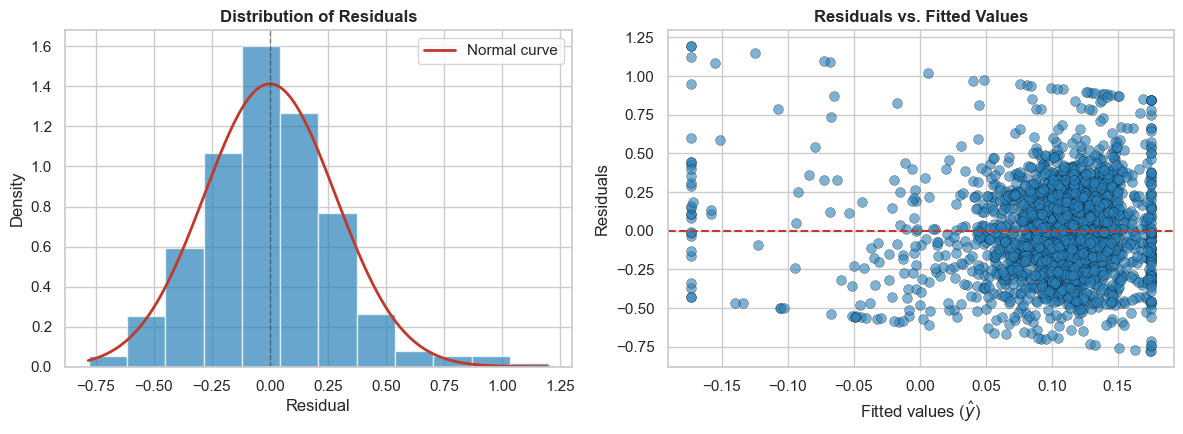

Mean of residuals: 0.00000000  (should be ~0)
Std of residuals:  0.282317


In [88]:
from scipy import stats

residuals = model.resid

fig, axes = plt.subplots(1, 2, figsize=(12, 4.5))

# Left: histogram of residuals
axes[0].hist(residuals, bins=12, color="#2980B9", alpha=0.7,
             edgecolor="white", density=True)
x_norm = np.linspace(residuals.min() - 0.002, residuals.max() + 0.002, 200)
axes[0].plot(x_norm,
             stats.norm.pdf(x_norm, loc=residuals.mean(), scale=residuals.std()),
             color="#C0392B", linewidth=2, label="Normal curve")
axes[0].axvline(0, color="#333", linestyle="--", linewidth=1, alpha=0.5)
axes[0].set_title("Distribution of Residuals", fontweight="bold")
axes[0].set_xlabel("Residual")
axes[0].set_ylabel("Density")
axes[0].legend()

# Right: residuals vs fitted values
axes[1].scatter(model.fittedvalues, residuals,
                color="#2980B9", alpha=0.6, s=50, edgecolor="black", linewidth=0.3)
axes[1].axhline(0, color="#666", linewidth=1.2, linestyle="--", label="y = 0 (zero residual)")
axes[1].set_title("Residuals vs. Fitted Values", fontweight="bold")
axes[1].set_xlabel("Fitted values ($\\hat{y}$)")
axes[1].set_ylabel("Residuals")
axes[1].legend()

plt.tight_layout()
plt.show()

print(f"Mean of residuals: {residuals.mean():.8f}  (should be ~0)")
print(f"Std of residuals:  {residuals.std():.6f}")

#### What to Look For

- **Left plot (histogram):** Do residuals look roughly normal (bell-shaped)? Good sign.
- **Right plot (residuals vs. fitted):** Do residuals spread evenly around zero, with no funnel shape or pattern? If yes, the **constant variance** assumption is plausible.

We will formally test these assumptions in **Week 6**.

---

## Part 9: Confidence Interval Visualization

The 95% confidence interval tells us the range of plausible values for the true slope. Let's visualize it.

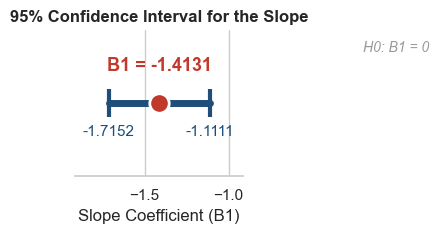

The null hypothesis (B1 = 0) is outside the 95% CI.
Therefore, we reject H0 at the 5% significance level.


In [89]:
fig, ax = plt.subplots(figsize=(8, 2.5))

# Draw the CI bar
ax.plot([ci_low, ci_high], [0, 0], color="#1F4E79", linewidth=5,
        solid_capstyle="round")
ax.plot(ci_low, 0, "|", color="#1F4E79", markersize=20, markeredgewidth=3)
ax.plot(ci_high, 0, "|", color="#1F4E79", markersize=20, markeredgewidth=3)

# Point estimate
ax.plot(slope, 0, "o", color="#C0392B", markersize=14,
        markeredgecolor="white", markeredgewidth=2)

# Labels
ax.text(slope, 0.18, f"B1 = {slope:.4f}", ha="center", fontsize=13,
        fontweight="bold", color="#C0392B")
ax.text(ci_low, -0.18, f"{ci_low:.4f}", ha="center", fontsize=11, color="#1F4E79")
ax.text(ci_high, -0.18, f"{ci_high:.4f}", ha="center", fontsize=11, color="#1F4E79")

# H0 reference
ax.axvline(0, color="#999", linestyle="--", linewidth=1)
ax.text(0, 0.28, "H0: B1 = 0", ha="center", fontsize=10,
        color="#999", fontstyle="italic")

# Formatting
margin = max(0.2, (ci_high - ci_low) * 0.3)
ax.set_xlim(min(ci_low - margin, -0.05), ci_high + margin)
ax.set_ylim(-0.4, 0.4)
ax.set_xlabel("Slope Coefficient (B1)", fontsize=12)
ax.set_yticks([])
for spine in ["top", "right", "left"]:
    ax.spines[spine].set_visible(False)
ax.set_title("95% Confidence Interval for the Slope", fontweight="bold")

plt.tight_layout()
plt.show()

print(f"The null hypothesis (B1 = 0) is {'inside' if ci_low <= 0 <= ci_high else 'outside'} the 95% CI.")
print(f"Therefore, we {'fail to reject' if ci_low <= 0 <= ci_high else 'reject'} H0 at the 5% significance level.")

---

## Part 10: Thinking About What We're Missing

Our model has one predictor (dividend yield). In reality, many things affect individual REIT returns:

| Omitted Variable | Why It Might Matter |
|:-----------------|:--------------------|
| **Market cap (size)** | Larger REITs may have different return patterns; size and dividend yield can be correlated |
| Sector | Different property sectors (Retail, Office, Industrial) have different return patterns |
| Interest rates | REITs are rate-sensitive; rates affect valuations and returns |
| Momentum | Past returns may predict future returns |
| Value (e.g., P/FFO) | Valuation ratios may be related to both dividend yield and returns |
| Volatility | Riskier REITs may earn different returns |

If any of these are correlated with **both** `div_yield` and `ret`, our slope estimate could be **biased**. This is called **omitted variable bias**. In the exercises below, you will try adding market cap as a secondary predictor.

We will address this more formally in **Week 5** by adding multiple predictors to the model.

---

## Part 10a: Secondary Analysis — Market Cap

So far we focused on **dividend yield** as the main predictor. Now let's try **market cap** as a secondary analysis. How does the size–return relationship compare to the dividend-yield–return relationship?

In [90]:
# Fit ret ~ mcap (secondary model)
model_mcap = ols("ret ~ mcap", data=df).fit()

print("Comparison: Dividend Yield vs. Market Cap")
print("=" * 50)
print(f"  Model 1 (ret ~ div_yield): R² = {model.rsquared:.4f}, slope = {model.params['div_yield']:.6f}")
print(f"  Model 2 (ret ~ mcap):      R² = {model_mcap.rsquared:.4f}, slope = {model_mcap.params['mcap']:.6f}")
print()
print("Which predictor explains more variation in returns?")

Comparison: Dividend Yield vs. Market Cap
  Model 1 (ret ~ div_yield): R² = 0.0323, slope = -1.413132
  Model 2 (ret ~ mcap):      R² = 0.0003, slope = 0.000000

Which predictor explains more variation in returns?


---

## Part 11: Your Turn -- Practice Exercises

Try these exercises on your own. They will help you prepare for **Assignment 04** (due Friday).

### Exercise 1: Try Log(Market Cap)

We already ran `ret ~ mcap` in Part 10a. Now try regressing returns on the **log of market cap**:

```python
df["log_mcap"] = np.log(df["mcap"])
model2 = ols("ret ~ log_mcap", data=df).fit()
```

- Is the slope positive or negative?
- Is it statistically significant?
- How does R-squared compare to the dividend-yield model and the level mcap model? (Interpretation: log(mcap) = "a 1% increase in mcap")

In [91]:
# Exercise 1: Your code here



### Exercise 2: By Year

Create a subset of the data for a single year (e.g., 2020) and run the dividend-yield regression:

```python
df_2020 = df[df["year"] == 2020]
model3 = ols("ret ~ div_yield", data=df_2020).fit()
```

- Does the slope change compared to the full sample?
- Is the relationship stronger or weaker in that year?
- Why might results differ across time periods?

In [92]:
# Exercise 2: Your code here



### Exercise 3: Create a Scatter Plot

Pick either Exercise 1 (log mcap) or 2 (by year) and create a scatter plot with the fitted regression line (like Part 7).

Make sure your plot has:
- A descriptive title
- Axis labels with the variable names
- A legend
- An R-squared annotation

In [93]:
# Exercise 3: Your code here



### Exercise 4: Write an Interpretation

In the markdown cell below, write a 2--3 sentence interpretation of the **dividend-yield model** (ret ~ div_yield) from the main analysis. Follow the template from Part 6:

1. State the slope, what it means in economic units
2. State the statistical significance (cite t-stat and p-value)
3. State the R-squared and what it implies

*Your interpretation here:*

...

---

## Summary

| Concept | Key Takeaway |
|:--------|:-------------|
| **OLS** | Finds the line minimizing squared residuals |
| **Slope ($\beta_1$)** | Change in Y per 1-unit change in X |
| **Intercept ($\beta_0$)** | Predicted Y when X = 0 |
| **t-statistic** | `coef / std err` -- tests if coefficient differs from zero |
| **p-value** | Probability of observing this result if true effect = 0 |
| **95% CI** | Range of plausible values for the true coefficient |
| **R-squared** | Proportion of variance in Y explained by X (0 to 1) |
| **Residuals** | Actual - Predicted; should be centered at zero |

---

## What's Next

- **Friday:** Complete **Assignment 04** -- estimate `ret ~ div_yield`, create a scatter plot, and write an interpretation memo. Due at 11:59 PM.
- **Week 5:** Multiple regression -- add sector, momentum, or other predictors to explain what our simple model misses.
- **Week 6:** Regression diagnostics -- formally test the Gauss-Markov assumptions.

---

*QM 2023 | Statistics II / Data Analytics | Spring 2026*